# Documentation for Standard Keras Neural Network
- ROC AUC for different masses
- learning curve
- validation curves

# Standard imports

In [154]:
! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_ge6jge4b.h5

--2019-02-27 13:41:46--  https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_ge6jge4b.h5
Resolving jglatzer.web.cern.ch (jglatzer.web.cern.ch)... 188.184.64.89, 2001:1458:201:a4::100:53
Connecting to jglatzer.web.cern.ch (jglatzer.web.cern.ch)|188.184.64.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83895032 (80M) [text/plain]
Saving to: ‘pandas_ge6jge4b.h5.1’

pandas_ge6jge4b.h5. 100%[===================>]  80.01M  19.0MB/s    in 7.7s    

2019-02-27 13:41:55 (10.4 MB/s) - ‘pandas_ge6jge4b.h5.1’ saved [83895032/83895032]



In [1]:

! git clone https://github.com/JulianGlatzer/HplusML
import sys
sys.path.append("HplusML")
#! export PYTHONPATH=$PYTHONPATH:`pwd`/HplusML
#! echo $PYTHONPATH

Cloning into 'HplusML'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 46 (delta 19), reused 38 (delta 11), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import HpAlgorithms
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

In [156]:
df_mc=pd.read_hdf('pandas_ge6jge4b.h5', 'INC_ge6jge4b')
df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc","Hp800"] else False)]
#print df_mc.process.shape
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp800'], dtype=object)

In [157]:
df_mc.columns

Index([u'index', u'Muu_MindR_70', u'nJets', u'Mbb_MindR_70', u'HT_jets',
       u'H1_all', u'Mjjj_MaxPt', u'Mbb_MaxPt_70', u'dRbb_avg_70',
       u'eventNumber', u'pT_jet5', u'dRlepbb_MindR_70', u'nBTags_70',
       u'Mbb_MaxM_70', u'jet_pt', u'Centrality_all', u'weight', u'process',
       u'group', u'region', u'pT_jet1', u'hpmass'],
      dtype='object')

# Prepare data for H+ classification

split into test and training data

In [0]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc) 

In [160]:
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=800)
summarizeFitData(X_train, y_train, w=w_train)

sb=MultiSBWeightsScaler(backgroundclass=0)
sb.fit(X_train,y_train, sample_weight=w_train)
X_train=sb.transform(X_train,y_train, sample_weight=w_train)
X_test=sb.transform(X_test,y_test, sample_weight=w_test)
#w_train.groupby(y_train).sum()
summarizeFitData(X_train, y_train, w=w_train)

wss=WeightedStandardScaler()
wss.fit(X_train,sample_weight=w_train)
X_train=wss.transform(X_train)
X_test=wss.transform(X_test)
#X_eval=wss.transform(X_eval)
summarizeFitData(X_train, y_train, w=w_train)
summarizeFitData(X_test, y_test, w=w_test)

X.shape= (23068, 14) y.shape= (23068,) w.shape= (23068,)
columns= Index([u'nJets', u'nBTags_70', u'pT_jet1', u'Mbb_MindR_70', u'pT_jet5',
       u'H1_all', u'dRbb_avg_70', u'dRlepbb_MindR_70', u'Muu_MindR_70',
       u'HT_jets', u'Mbb_MaxPt_70', u'Mbb_MaxM_70', u'Mjjj_MaxPt',
       u'Centrality_all'],
      dtype='object')
categories= [0, 1]

sum of weights per category
       all 1464.08896891
         0 1457.10675797
         1 6.98221093499


average
  variable/class        all          0          1
           nJets       6.99       6.99       7.43
       nBTags_70       4.06       4.06        4.1
         pT_jet1   1.77e+05   1.77e+05   2.96e+05
    Mbb_MindR_70   7.76e+04   7.73e+04   1.33e+05
         pT_jet5   5.06e+04   5.05e+04   6.68e+04
          H1_all      0.226      0.227      0.182
     dRbb_avg_70       2.28       2.28       2.42
dRlepbb_MindR_70       2.31       2.31       2.17
    Muu_MindR_70   1.05e+05   1.05e+05   1.06e+05
         HT_jets   5.69e+05   5.68e+05   

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def get_model(layers=[20,10,5]):
  model = Sequential()
  for i,layer in enumerate(layers):
    if i==0:
      model.add(Dense(layer, input_dim=14, activation='relu'))    
    else:
      model.add(Dense(layer, activation='relu'))
    #model.add(Dropout(rate=0.5))
  model.add(Dense(1, activation='sigmoid'))
  #model.add(Dense(5, activation='relu'))
  #model.add(Dense(1, input_dim=14, activation='sigmoid'))

  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  model.summary()
  return model

In [176]:
epochs=15
callbacks=[keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                         patience=3),
           keras.callbacks.ModelCheckpoint(filepath='model_nn.h5', 
                                           monitor='val_loss',
                                          save_best_only=True),
           roc_callback(training_data=(X_train.values, y_train.values, w_train.values),validation_data=(X_test.values, y_test.values, w_test.values))
          ]
history=model.fit(X_train.values,y_train.values, sample_weight=w_train.values, batch_size=50, epochs=epochs, callbacks=callbacks, validation_data=(X_test.values, y_test.values, w_test.values))

Train on 23068 samples, validate on 23217 samples
Epoch 1/15
23068/23068 [==============================] - 3s 124us/step - loss: 2.0821e-05 - binary_accuracy: 0.8032 - val_loss: 2.2285e-05 - val_binary_accuracy: 0.7942
roc-auc: 0.896 - roc-auc_val: 0.885
Epoch 2/15
23068/23068 [==============================] - 3s 134us/step - loss: 2.0776e-05 - binary_accuracy: 0.8048 - val_loss: 2.2351e-05 - val_binary_accuracy: 0.8037
roc-auc: 0.8963 - roc-auc_val: 0.8855
Epoch 3/15
23068/23068 [==============================] - 3s 133us/step - loss: 2.0774e-05 - binary_accuracy: 0.8040 - val_loss: 2.2355e-05 - val_binary_accuracy: 0.8008
roc-auc: 0.8963 - roc-auc_val: 0.8841
Epoch 4/15
23068/23068 [==============================] - 3s 133us/step - loss: 2.0805e-05 - binary_accuracy: 0.8040 - val_loss: 2.2179e-05 - val_binary_accuracy: 0.7985
roc-auc: 0.8972 - roc-auc_val: 0.8849
Epoch 5/15
23068/23068 [==============================] - 3s 134us/step - loss: 2.0752e-05 - binary_accuracy: 0.8049 - v

In [180]:
history.history.keys()
callbacks[2].roc_val

[0.8850495660501853,
 0.8854880929412016,
 0.8840720973956541,
 0.884863529154461,
 0.884253822222707]

In [135]:
for layer in model.layers:
  print layer.name,"out=", layer.output[0]

dense_26 out= Tensor("strided_slice_4:0", shape=(20,), dtype=float32)
dense_27 out= Tensor("strided_slice_5:0", shape=(10,), dtype=float32)
dense_28 out= Tensor("strided_slice_6:0", shape=(5,), dtype=float32)
dense_29 out= Tensor("strided_slice_7:0", shape=(1,), dtype=float32)


In [0]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.w = training_data[2]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.w_val = validation_data[2]
        self.roc=[]
        self.roc_val=[]
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred, sample_weight=self.w)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val, sample_weight=self.w_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))))
        self.roc_val.append(roc_val)
        self.roc.append(roc)
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [192]:
from sklearn.metrics import roc_curve,roc_auc_score, auc

configurations=[[14,8],
                [20,8],
                [14,12],
                [20,12]
               ]
roc_values={}
epochs=15


for configuration in configurations:
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                         patience=3),
           keras.callbacks.ModelCheckpoint(filepath='model_nn_'+str(configuration)+'.hdf5', 
                                           monitor='val_loss',
                                          save_best_only=True)
          ]
  model=get_model(layers=configuration)
  history=model.fit(X_train.values,y_train.values, sample_weight=w_train.values, batch_size=50, epochs=epochs, callbacks=callbacks, validation_data=(X_test.values, y_test.values, w_test.values))
  model.load_weights("model_nn_"+str(configuration)+".hdf5")
  y_pred=model.predict(X_test).ravel()
  roc=roc_auc_score(y_test, y_pred, sample_weight=w_test)
  print configuration, roc
  roc_values[str(configuration)]=roc

  
for key in roc_values.keys():
  print key, roc_values[key]
  
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 14)                210       
_________________________________________________________________
dense_84 (Dense)             (None, 8)                 120       
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 9         
Total params: 339
Trainable params: 339
Non-trainable params: 0
_________________________________________________________________
Train on 23068 samples, validate on 23217 samples
Epoch 1/15
23068/23068 [==============================] - 5s 210us/step - loss: 2.8721e-05 - binary_accuracy: 0.7220 - val_loss: 2.4653e-05 - val_binary_accuracy: 0.7816
Epoch 2/15
23068/23068 [==============================] - 3s 133us/step - loss: 2.3663e-05 - binary_accuracy: 0.7841 - val_loss: 2.3716e-05 - val_binary_accuracy: 0.7816
Epoch 3/15
23068/2

['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy']


Text(0,0.5,'Accuracy')

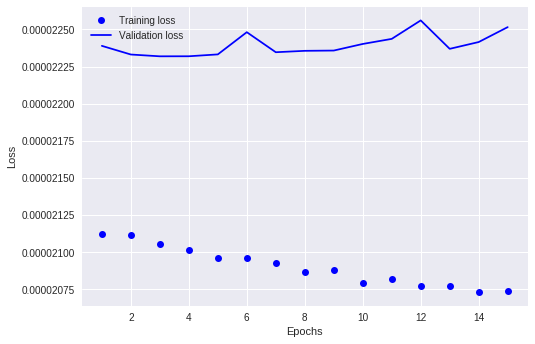

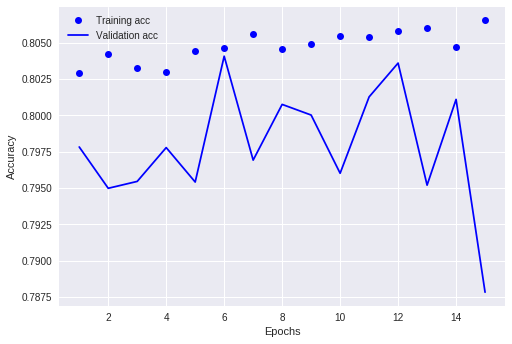

In [133]:
import matplotlib.pyplot as plt
print history.history.keys()
loss_values=history.history['loss']
val_loss_values=history.history['val_loss']
acc_values=history.history['binary_accuracy']
val_acc_values=history.history['val_binary_accuracy']

epochs=range(1,len(acc_values)+1)
plt.figure()
plt.plot(epochs, loss_values, "bo",label="Training loss")
plt.plot(epochs, val_loss_values, "b",label="Validation loss")
plt.legend(loc=0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax=plt.figure()
plt.plot(epochs, acc_values, "bo",label="Training acc")
plt.plot(epochs, val_acc_values, "b",label="Validation acc")
plt.legend(loc=0)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
#print history.history.keys()
#print lossvalues

['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy']


Text(0,0.5,'Accuracy')

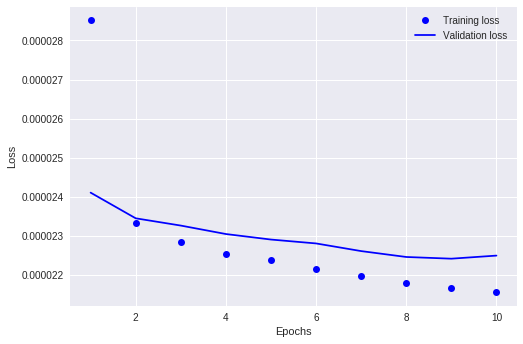

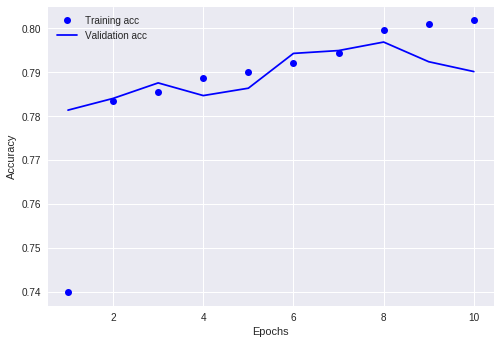

In [127]:
import matplotlib.pyplot as plt
print history.history.keys()
loss_values=history.history['loss']
val_loss_values=history.history['val_loss']
acc_values=history.history['binary_accuracy']
val_acc_values=history.history['val_binary_accuracy']

epochs=range(1,len(acc_values)+1)
plt.figure()
plt.plot(epochs, loss_values, "bo",label="Training loss")
plt.plot(epochs, val_loss_values, "b",label="Validation loss")
plt.legend(loc=0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax=plt.figure()
plt.plot(epochs, acc_values, "bo",label="Training acc")
plt.plot(epochs, val_acc_values, "b",label="Validation acc")
plt.legend(loc=0)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
#print history.history.keys()
#print lossvalues

In [140]:
y_pred=model.predict(X_test).ravel()

array([0.8706987 , 0.784187  , 0.8711462 , ..., 0.96393836, 0.22757512,
       0.29982105], dtype=float32)

In [164]:
from sklearn.metrics import roc_curve,roc_auc_score, auc
y_pred=model.predict(X_test).ravel()
print roc_auc_score(y_test, y_pred, sample_weight=w_test)

0.8853078263981311


In [148]:
import HpAlgorithms
clf=HpAlgorithms.getGradientBDTClassifier()
Xbdt_train, Xbdt_test, Xbdt_eval, ybdt_train, ybdt_test,ybdt_eval, wbdt_train, wbdt_test, wbdt_eval=htf.prepare(hpmass=800)
summarizeFitData(Xbdt_train, ybdt_train, w=wbdt_train)
sb=MultiSBWeightsScaler(backgroundclass=0)
sb.fit(Xbdt_train,ybdt_train, sample_weight=wbdt_train)
Xbdt_train=sb.transform(Xbdt_train,ybdt_train, sample_weight=wbdt_train)
Xbdt_test=sb.transform(Xbdt_test,ybdt_test, sample_weight=wbdt_test)
summarizeFitData(Xbdt_train, ybdt_train, w=wbdt_train)
clf.fit(Xbdt_train,ybdt_train, sample_weight=wbdt_train)

X.shape= (23068, 14) y.shape= (23068,) w.shape= (23068,)
columns= Index([u'nJets', u'nBTags_70', u'pT_jet1', u'Mbb_MindR_70', u'pT_jet5',
       u'H1_all', u'dRbb_avg_70', u'dRlepbb_MindR_70', u'Muu_MindR_70',
       u'HT_jets', u'Mbb_MaxPt_70', u'Mbb_MaxM_70', u'Mjjj_MaxPt',
       u'Centrality_all'],
      dtype='object')
categories= [0, 1]

sum of weights per category
       all 1464.08896891
         0 1457.10675797
         1 6.98221093499


average
  variable/class        all          0          1
           nJets       6.99       6.99       7.43
       nBTags_70       4.06       4.06        4.1
         pT_jet1   1.77e+05   1.77e+05   2.96e+05
    Mbb_MindR_70   7.76e+04   7.73e+04   1.33e+05
         pT_jet5   5.06e+04   5.05e+04   6.68e+04
          H1_all      0.226      0.227      0.182
     dRbb_avg_70       2.28       2.28       2.42
dRlepbb_MindR_70       2.31       2.31       2.17
    Muu_MindR_70   1.05e+05   1.05e+05   1.06e+05
         HT_jets   5.69e+05   5.68e+05   

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.13, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=120,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [149]:
print roc_auc_score(ybdt_test, clf.decision_function(Xbdt_test), sample_weight=wbdt_test)

0.8837703139912665
